# **Jakarta Air Pollution Predictor**

## **Gathering Data**

In [1]:
!pip install meteostat
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.3/684.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.8 MB/s eta 0:00:00


In [2]:
from os import pathconf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from meteostat import Point, Daily
from datetime import datetime
import pytz

np.random.seed(42)

# Location (South Jakarta)
path = '/content/drive/MyDrive/Data Science/Jakarta Air Pollution Pred/jakarta-air-quality.csv'

# PM2.5 pollution value
df_pollution = pd.read_csv(path)

# Set date to datetime format
df_pollution.rename(columns = {' pm25': 'pm25', ' date': 'date'}, inplace=True)
df_pollution['date'] = pd.to_datetime(df_pollution['date'])

df_pollution.drop([' pm10'], axis=1, inplace=True)

# Change data type of PM2.5
df_pollution['pm25'] = df_pollution['pm25'].replace(' ', '')
df_pollution['pm25'] = df_pollution['pm25'].replace('', np.nan)
df_pollution['pm25'] = df_pollution['pm25'].astype('Int64')

print(df_pollution.head())

# WEATHER DATA
# Nearest location to South Jakarta
location = Point(-6.1833, 106.8333)

# Set to local timezone
local_tz = pytz.timezone('Asia/Jakarta')
start_local = datetime(2020, 1, 1)
end_local = datetime(2025, 10, 1)

# Fetch data (Meteostat internally uses UTC)
data = Daily(location, start_local, end_local)
df_weather = pd.DataFrame(data.fetch())

# Convert back to local time
df_weather.index = df_weather.index.tz_localize('UTC').tz_convert('Asia/Jakarta').tz_localize(None)

# Create default index, set date to datetime format
df_weather['date'] = pd.to_datetime(df_weather.index)
df_weather.index = range(len(df_weather))

# All null values
df_weather.drop(['snow', 'wpgt', 'tsun', 'wdir'], axis=1, inplace=True)

df_weather.rename(columns = {'tavg': 'temp_avg',
                             'tmin': 'temp_min',
                             'tmax': 'temp_max',
                             'prcp': 'precip',
                             'wspd': 'wind_speed'}, inplace=True)

print(df_weather.tail())

        date  pm25
0 2025-10-01    96
1 2025-10-02    92
2 2025-10-03    80
3 2025-10-04    85
4 2025-10-05   163


      temp_avg  temp_min  temp_max  precip  wind_speed    pres  \
2096      27.6      23.9      32.6     8.0         8.9  1010.3   
2097      28.0      25.3      33.7     8.9        12.4  1010.5   
2098      26.6      24.1      30.7    16.9         9.0  1011.4   
2099      26.2      23.9      29.4    14.4         9.2  1010.6   
2100      26.0      24.0      29.3     6.7        10.6  1010.4   

                    date  
2096 2025-09-27 07:00:00  
2097 2025-09-28 07:00:00  
2098 2025-09-29 07:00:00  
2099 2025-09-30 07:00:00  
2100 2025-10-01 07:00:00  


In [3]:
print(df_pollution.info())
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2820 non-null   datetime64[ns]
 1   pm25    2102 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 46.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp_avg    2101 non-null   Float64       
 1   temp_min    2101 non-null   Float64       
 2   temp_max    2101 non-null   Float64       
 3   precip      1715 non-null   Float64       
 4   wind_speed  2101 non-null   Float64       
 5   pres        2101 non-null   Float64       
 6   date        2101 non-null   datetime64[ns]
dtypes: Float64(6), datetime64[ns](1)
memory usage: 127.3 KB
None


In [4]:
# Match date formats
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.normalize()
df_pollution['date'] = pd.to_datetime(df_pollution['date']).dt.normalize()

# Merge weather features and pollution value dataframes
df_all = pd.merge(df_pollution, df_weather, on="date", how="inner")
df_all.sort_values(by='date')

# Fill in missing dates by setting date as the index
df_all = df_all.set_index("date").asfreq("D")
df_all['date'] = pd.to_datetime(df_all.index)
df_all = df_all.drop(['date'], axis=1)

print(df_all)

            pm25  temp_avg  temp_min  temp_max  precip  wind_speed    pres
date                                                                      
2020-01-01  <NA>      26.7      25.1      28.8    <NA>        11.7  1012.0
2020-01-02  <NA>      27.8      25.0      30.8    <NA>         8.9  1012.6
2020-01-03  <NA>      28.6      25.4      31.0    <NA>        11.1  1011.0
2020-01-04  <NA>      28.5      25.6      31.2    <NA>        12.0  1009.3
2020-01-05  <NA>      27.6      26.3      29.6    <NA>        11.7  1009.3
...          ...       ...       ...       ...     ...         ...     ...
2025-09-27   114      27.6      23.9      32.6     8.0         8.9  1010.3
2025-09-28    82      28.0      25.3      33.7     8.9        12.4  1010.5
2025-09-29   109      26.6      24.1      30.7    16.9         9.0  1011.4
2025-09-30   147      26.2      23.9      29.4    14.4         9.2  1010.6
2025-10-01    96      26.0      24.0      29.3     6.7        10.6  1010.4

[2101 rows x 7 columns]


In [5]:
# Find empty rows
features = ['pm25', 'temp_avg', 'temp_min', 'temp_max', 'precip', 'wind_speed', 'pres']

# Rows that are not completely full
condition_has_missing = ~df_all[features].notna().all(axis=1)

# Rows that are not completely empty
condition_has_present = ~df_all[features].isna().all(axis=1)

# Apply both conditions to find rows that are partially filled
partial_rows = df_all[condition_has_missing & condition_has_present]

print(partial_rows)

            pm25  temp_avg  temp_min  temp_max  precip  wind_speed    pres
date                                                                      
2020-01-01  <NA>      26.7      25.1      28.8    <NA>        11.7  1012.0
2020-01-02  <NA>      27.8      25.0      30.8    <NA>         8.9  1012.6
2020-01-03  <NA>      28.6      25.4      31.0    <NA>        11.1  1011.0
2020-01-04  <NA>      28.5      25.6      31.2    <NA>        12.0  1009.3
2020-01-05  <NA>      27.6      26.3      29.6    <NA>        11.7  1009.3
...          ...       ...       ...       ...     ...         ...     ...
2025-03-17    51      28.0      26.6      29.3    <NA>        10.0  1008.9
2025-03-18    46      28.0      26.1      30.0    <NA>        10.2  1009.9
2025-03-19    58      28.2      26.3      30.2    <NA>        10.0  1011.1
2025-03-20    57      28.3      26.4      30.2    <NA>         9.3  1011.6
2025-03-21    45      28.6      26.5      30.4    <NA>         9.0  1011.8

[467 rows x 7 columns]


# **Exploratory Data Analysis** #

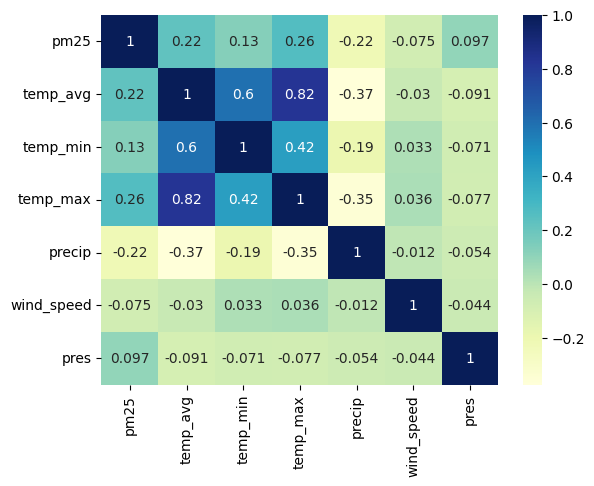

In [6]:
# Correlation plot
sns.heatmap(df_all.corr(), annot=True, cmap="YlGnBu")
plt.show()

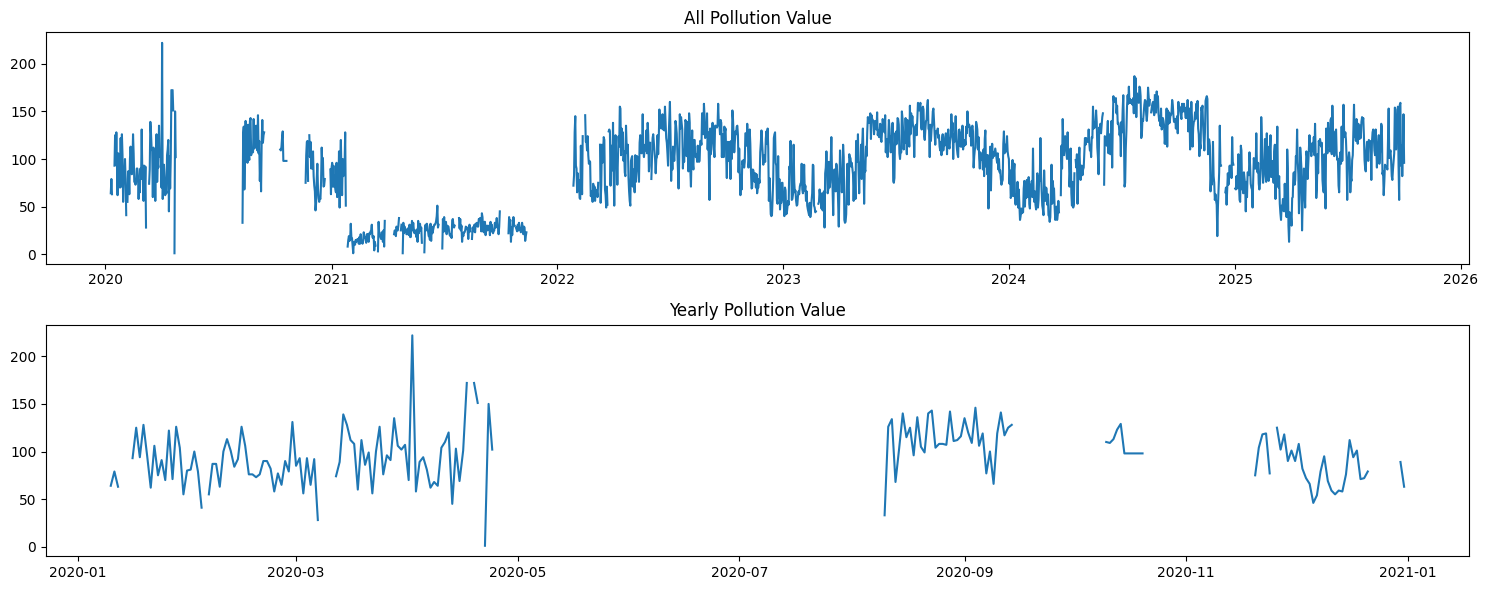

In [7]:
# Before Interpolating
section = (df_all.index > datetime(2020, 1, 1)) & (df_all.index < datetime(2021, 1, 1))

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].plot(df_all.index, df_all["pm25"])
axes[0].set_title("All Pollution Value")

axes[1].plot(df_all[section].index, df_all[section]["pm25"])
axes[1].set_title("Yearly Pollution Value")

plt.tight_layout()
plt.show()

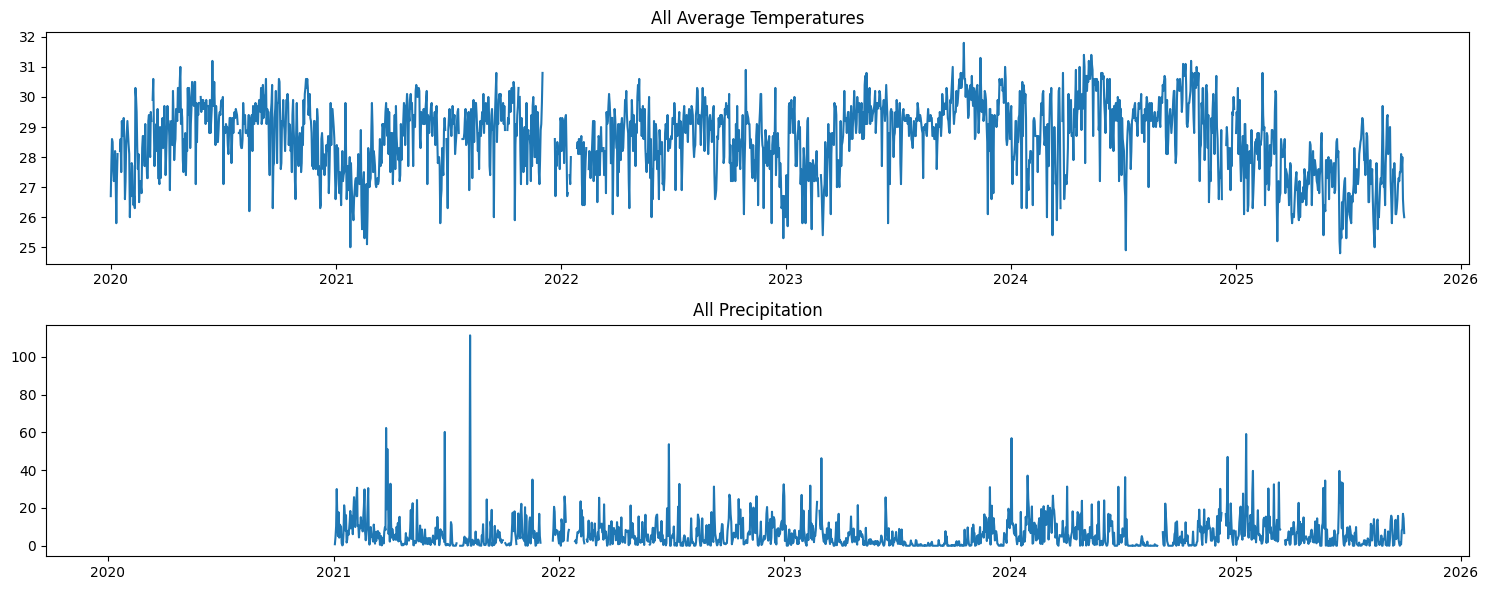

In [8]:
# Line graphs of Average Temperature and Precipitation
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].plot(df_all.index, df_all["temp_avg"])
axes[0].set_title("All Average Temperatures")

axes[1].plot(df_all.index, df_all["precip"])
axes[1].set_title("All Precipitation")

plt.tight_layout()
plt.show()

In [9]:
# Interpolate
features = ['pm25', 'temp_avg', 'temp_min', 'temp_max', 'precip', 'wind_speed', 'pres']

for i in features:
  df_all.loc[:, i] = df_all[i].interpolate(method='time', limit=5)

[ <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  64.0,
 ...
  93.0,  57.0, 157.0, 159.0,  93.0, 114.0,  82.0, 109.0, 147.0,  96.0]
Length: 2101, dtype: Float64' has dtype incompatible with Int64, please explicitly cast to a compatible dtype first.


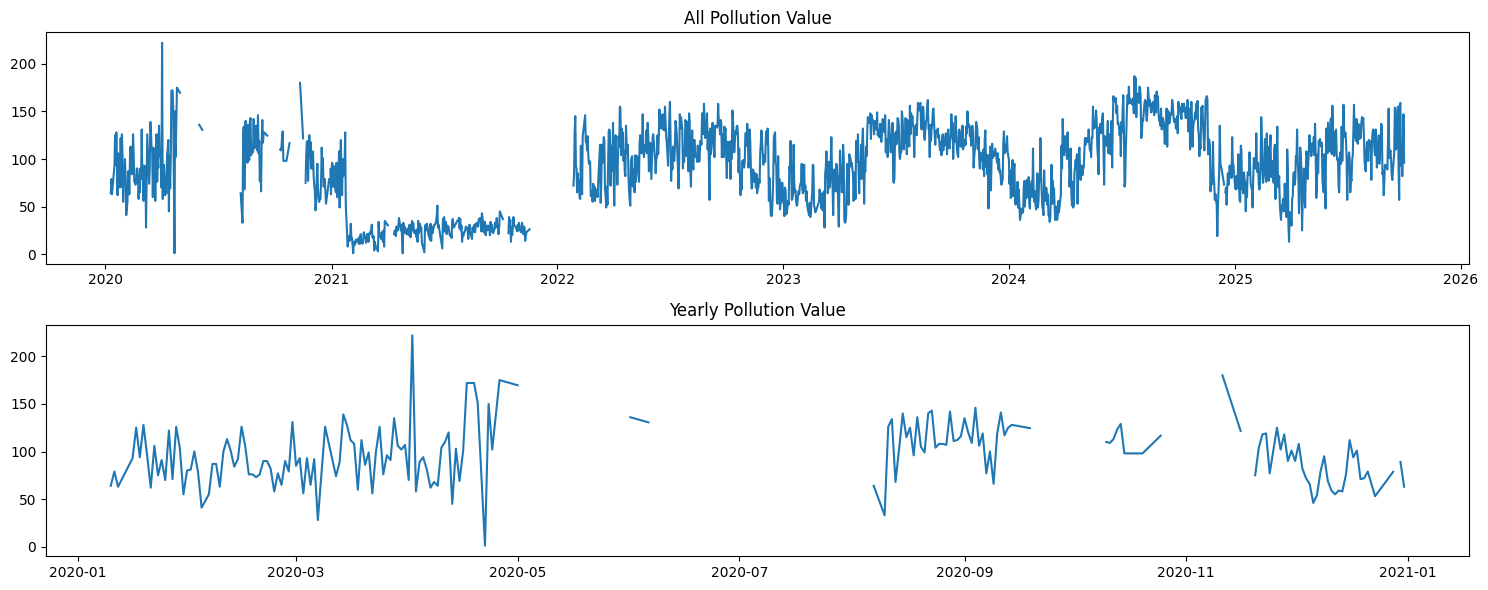

In [10]:
# After Interpolating
section = (df_all.index > datetime(2020, 1, 1)) & (df_all.index < datetime(2021, 1, 1))

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].plot(df_all.index, df_all["pm25"])
axes[0].set_title("All Pollution Value")

axes[1].plot(df_all[section].index, df_all[section]["pm25"])
axes[1].set_title("Yearly Pollution Value")

plt.tight_layout()
plt.show()

In [11]:
# Drop 2020
df_aft20 = df_all[df_all.index > '2020-12-31']

# Split at end of 2021
df1 = df_aft20[df_aft20.index < '2021-12-03'].copy()
df2 = df_aft20[df_aft20.index >= '2022-01-27'].copy()

df_filtered = pd.concat([df1, df2]).sort_index()

# Transform date into tabular data
df_filtered.loc[:, 'day_of_week'] = df_filtered.index.dayofweek
df_filtered.loc[:, 'day_of_month'] = df_filtered.index.day
df_filtered.loc[:,'month'] = df_filtered.index.month
df_filtered.loc[:,'year'] = df_filtered.index.year
df_filtered.index = range(len(df_filtered))

In [12]:
print(df_filtered[df_filtered[features].isna().any(axis=1)].head())

    pm25  temp_avg  temp_min  temp_max  precip  wind_speed    pres  \
0   91.0      27.1      25.0      30.0    <NA>         9.9  1008.7   
1   96.0      28.4      25.0      31.2    <NA>         6.4  1008.7   
92  <NA>      27.1      25.0      29.8    32.8         5.1  1008.3   
93  <NA>      28.0      25.2      30.2    11.8         4.6  1008.6   
94  <NA>      28.6      25.0      32.0     4.3         4.6  1009.0   

    day_of_week  day_of_month  month  year  
0             4             1      1  2021  
1             5             2      1  2021  
92            5             3      4  2021  
93            6             4      4  2021  
94            0             5      4  2021  


In [13]:
# Drop null values
df = df_filtered.dropna().copy()
df.head()

,pm25,temp_avg,temp_min,temp_max,precip,wind_speed,pres,day_of_week,day_of_month,month,year
2,71.0,27.6,25.0,32.4,0.8,9.7,1008.5,6,3,1,2021
3,93.0,28.3,25.6,32.6,4.6,7.9,1008.4,0,4,1,2021
4,71.0,27.3,24.2,29.6,10.3,4.8,1008.3,1,5,1,2021
5,83.0,26.8,24.0,30.6,30.0,5.3,1008.0,2,6,1,2021
6,69.0,27.5,24.0,29.8,14.4,3.9,1007.5,3,7,1,2021


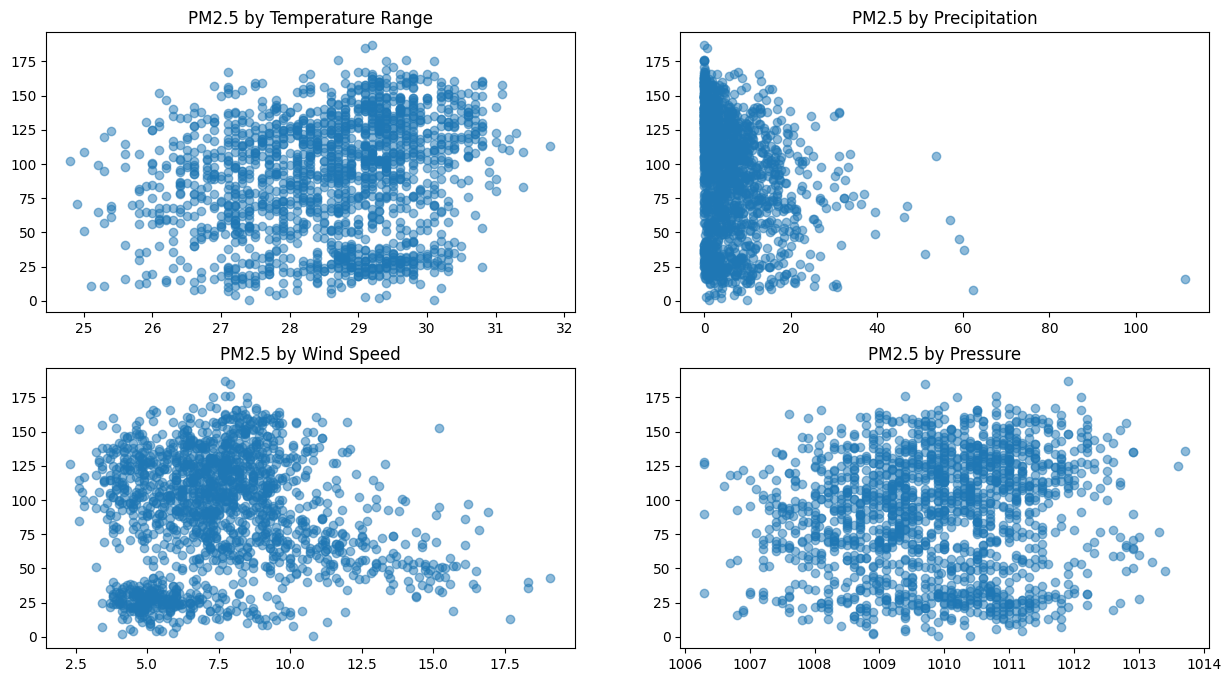

In [14]:
# Scatter plots against PM2.5
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

axes[0, 0].scatter(df['temp_avg'], df["pm25"], alpha=0.5)
axes[0, 0].set_title("PM2.5 by Temperature Range")

axes[0, 1].scatter(df['precip'], df["pm25"], alpha=0.5)
axes[0, 1].set_title("PM2.5 by Precipitation")

axes[1, 0].scatter(df['wind_speed'], df["pm25"], alpha=0.5)
axes[1, 0].set_title("PM2.5 by Wind Speed")

axes[1, 1].scatter(df['pres'], df["pm25"], alpha=0.5)
axes[1, 1].set_title("PM2.5 by Pressure")

plt.show()

- Higher wind speeds = low pollution (negative corr)
- Higher precipitation = low pollution (negative corr)

In [15]:
# Tree-based models may not need additional features (test both later)
df_tree = df.copy()

# Interaction features
df['temp_avg_precip'] = df['temp_avg'] * df['precip']
df['temp_avg_wind_speed'] = df['temp_avg'] * df['wind_speed']
df['temp_avg_pres'] = df['temp_avg'] * df['pres']

df['temp_min_precip'] = df['temp_min'] * df['precip']
df['temp_min_wind_speed'] = df['temp_min'] * df['wind_speed']
df['temp_min_pres'] = df['temp_min'] * df['pres']

df['temp_max_precip'] = df['temp_max'] * df['precip']
df['temp_max_wind_speed'] = df['temp_max'] * df['wind_speed']
df['temp_max_pres'] = df['temp_max'] * df['pres']

df['wind_speed_pres'] = df['wind_speed'] * df['pres']
df['wind_speed_precip'] = df['wind_speed'] * df['precip']

df['pres_precip'] = df['pres'] * df['precip']

In [16]:
# Cyclical features
df.loc[:, 'week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df.loc[:, 'week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

df.loc[:, 'month_sin'] = np.sin(2 * np.pi * df['month']/12)
df.loc[:, 'month_cos'] = np.cos(2 * np.pi * df['month']/12)

df.loc[:, 'day_sin'] = np.sin(2 * np.pi * df['day_of_month']/31)
df.loc[:, 'day_cos'] = np.cos(2 * np.pi * df['day_of_month']/31)

In [17]:
# More features
df['temp_range'] = df['temp_max'] - df['temp_min']
df['dp1'] = df['pres'].diff(1)
df['dp3'] = df['pres'].diff(3)

p_lag1 = df['precip'].shift(1)
df['rain_any_1d'] = (df['precip'].shift(1) > 0).astype('float')
df['rain_sum_3d'] = p_lag1.rolling(3, min_periods=3).sum()
df['rain_sum_7d'] = p_lag1.rolling(7, min_periods=7).sum()

df['ws2'] = df['wind_speed']**2
df['ws_dtr'] = df['wind_speed'] * df['temp_range']
df['ws_pres'] = df['wind_speed'] * df['pres']

df = df.iloc[7:]

In [18]:
# Explore the mean, min, max of all features
df.describe()

,pm25,temp_avg,temp_min,temp_max,precip,wind_speed,pres,day_of_week,day_of_month,month,...,day_cos,temp_range,dp1,dp3,rain_any_1d,rain_sum_3d,rain_sum_7d,ws2,ws_dtr,ws_pres
count,1632.0,1632.0,1632.0,1632.0,1632.0,1632.0,1632.0,1632.000000,1632.000000,1632.000000,...,1632.000000,1632.0,1632.0,1632.0,1632.000000,1632.000000,1632.000000,1632.0,1632.0,1632.0
mean,90.658193,28.593938,25.11685,32.298687,6.236145,7.590564,1009.883154,2.995098,15.827206,6.245098,...,-0.019726,7.181836,0.001532,0.00576,0.892157,18.715728,43.718581,64.762249,54.527002,7665.59376
std,42.358002,1.228353,1.255629,1.527153,7.898061,2.673943,1.288059,2.000607,8.803714,3.248351,...,0.703767,1.478978,0.667173,1.174013,0.310277,17.323148,32.172352,48.459465,22.68025,2699.801079
min,1.0,24.8,19.8,26.8,0.0,2.3,1006.3,0.000000,1.000000,1.000000,...,-0.994869,2.0,-2.4,-3.8,0.000000,0.000000,0.000000,5.29,11.2,2323.23
25%,56.75,27.7,24.1,31.4,0.9,5.6,1009.0,1.000000,8.000000,3.000000,...,-0.758758,6.2,-0.4,-0.8,1.000000,6.000000,20.000000,31.36,38.5,5655.58
50%,97.0,28.8,25.0,32.4,3.8,7.3,1009.9,3.000000,16.000000,6.000000,...,-0.050649,7.0,0.0,0.0,1.000000,14.400000,37.700000,53.29,50.92,7373.365
75%,125.0,29.5,26.0,33.4,8.7,9.0,1010.8,5.000000,23.000000,9.000000,...,0.688967,8.2,0.5,0.8,1.000000,26.550000,60.800000,81.0,66.225,9087.3
max,187.0,31.8,28.2,36.8,111.3,19.1,1013.7,6.000000,31.000000,12.000000,...,1.000000,13.0,4.1,5.0,1.000000,132.800000,188.300000,364.81,193.98,19302.46


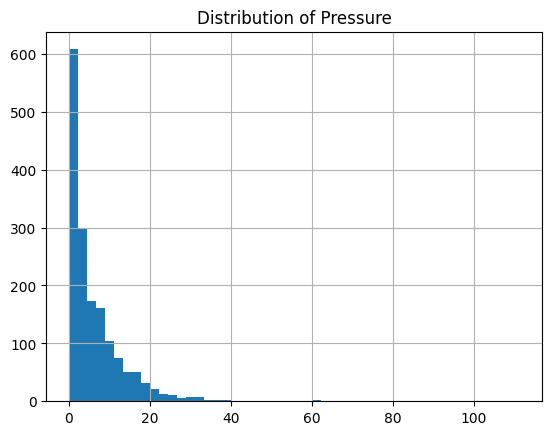

In [19]:
# Explore the distribution of different features (current: precipitation)
df['precip'].hist(bins=50)
plt.title('Distribution of Pressure')
plt.show()

## **Model Training and Evaluation**

In [20]:
# Split train test
split_idx = int(len(df) * 0.9)
train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

# Train test split
X_train = train.drop(['pm25'], axis=1)
y_train = train['pm25']

X_test = test.drop(['pm25'], axis=1)
y_test = test['pm25']

# Tree based models may or may not need to use cyclical features, test both and see which is better
X_train_tree = df_tree.iloc[:split_idx].drop(['pm25'], axis=1)
y_train_tree = df_tree.iloc[:split_idx]['pm25']

X_test_tree = df_tree.iloc[split_idx:].drop(['pm25'], axis=1)
y_test_tree = df_tree.iloc[split_idx:]['pm25']

# Match indexes
y_train = y_train.loc[X_train.index].copy()
y_test = y_test.loc[X_test.index].copy()

# Scale values
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Log transform precipitation as it is skewed
X_train['precip_log'] = np.log1p(X_train['precip'])
X_test['precip_log'] = np.log1p(X_test['precip'])

X_train = X_train.drop(['precip'], axis=1)
X_test = X_test.drop(['precip'], axis=1)

features = ['temp_avg', 'temp_min', 'temp_max', 'precip_log', 'wind_speed',
            'pres', 'temp_avg_precip', 'temp_avg_wind_speed', 'temp_avg_pres',
            'temp_min_precip', 'temp_min_wind_speed', 'temp_min_pres',
            'temp_max_precip', 'temp_max_wind_speed', 'temp_max_pres',
            'wind_speed_pres', 'wind_speed_precip', 'pres_precip',
            'temp_range', 'dp1', 'dp3', 'rain_any_1d', 'rain_sum_3d', 'rain_sum_7d',
            'ws2', 'ws_dtr', 'ws_pres']

scaler = StandardScaler().fit(X_train[features])

X_train[features] = X_train[features].astype("float64")
X_test[features] = X_test[features].astype("float64")

X_train[features] = scaler.transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

X_train.loc[:, 'year'] -= 2020
X_test.loc[:, 'year'] -= 2020

# Remove date features
features = ['day_of_week', 'day_of_month', 'month']

X_train = X_train.drop(features, axis=1)
X_test = X_test.drop(features, axis=1)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

cv = TimeSeriesSplit(n_splits=5)

# Function to test RMSE
def test_score(model, name, X_train_data, y_train_data):
  print(name)

  score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, verbose=0)
  print(f'Average RMSE: {-score.mean()}')

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

# Model hyperparameters already tuned using GridSearchCV & RandomSearchCV
lr = LinearRegression(fit_intercept=True)
rf = RandomForestRegressor(random_state=42, bootstrap=True, criterion='squared_error',
                           max_depth=20, max_features='sqrt', min_samples_leaf=1,
                           min_samples_split=10, n_estimators=500)

lgbm = LGBMRegressor(objective="regression", n_estimators=2500, learning_rate=0.02,
                     num_leaves=64, max_depth=-1, min_child_samples=60, min_split_gain=0.0,
                     subsample=0.8, subsample_freq=1, colsample_bytree=0.8, reg_lambda=1.0,
                     reg_alpha=0.0, bagging_seed=42, feature_fraction_seed=42, data_random_seed=42,
                     random_state=42, verbosity=-1)

xgbr = XGBRegressor(objective="reg:squarederror", n_estimators=3000, learning_rate=0.03,
                    max_depth=6, min_child_weight=20, subsample=0.8, colsample_bytree=0.8,
                    colsample_bynode=0.8, gamma=0.0, reg_lambda=1.5, reg_alpha=0.0, tree_method="hist",
                    random_state=42, eval_metric="rmse")

# Initial model scoring using cross validation
test_score(lr, 'Linear Regression', X_train, y_train)
print()
test_score(rf, 'Random Forest', X_train_tree, y_train_tree)
print()
test_score(lgbm, 'LGBM', X_train_tree, y_train_tree)
print()
test_score(xgbr, 'XGB', X_train_tree, y_train_tree)

Linear Regression
Average RMSE: 53.9095847280366

Random Forest
Average RMSE: 41.676505682308914

LGBM
Average RMSE: 38.926480096800006

XGB
Average RMSE: 37.64221000671387


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.03)),
    Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.03)),
    Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

In [24]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=20,
    restore_best_weights=True
)

In [25]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [26]:
# Validation set
val_frac = 0.2
n = len(X_train)
cut = int(n*(1-val_frac))
X_tr, y_tr = X_train[:cut], y_train[:cut]
X_val, y_val = X_train[cut:], y_train[cut:]


hist = model.fit(X_tr, y_tr, epochs=1000,
                 validation_data=[X_val, y_val], callbacks=[early_stop])

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 87.0785 - root_mean_squared_error: 93.0931 - val_loss: 116.0039 - val_root_mean_squared_error: 119.1012
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 86.5175 - root_mean_squared_error: 92.6946 - val_loss: 115.3960 - val_root_mean_squared_error: 118.6677
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85.9326 - root_mean_squared_error: 92.2876 - val_loss: 114.7036 - val_root_mean_squared_error: 118.1544
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85.3860 - root_mean_squared_error: 91.8766 - val_loss: 113.8558 - val_root_mean_squared_error: 117.4946
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84.6985 - root_mean_squared_error: 91.3539 - val_loss: 112.7236 - val_root_mean_squared_error: 116.5663
Epoch 6/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83.7096 - root_mean_squared_error: 90.5477 - val_loss: 111.1831 - val_root_mean_squared_error: 115.2610
Epoch 7/1000
37

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Average RMSE: 27.944700148452014


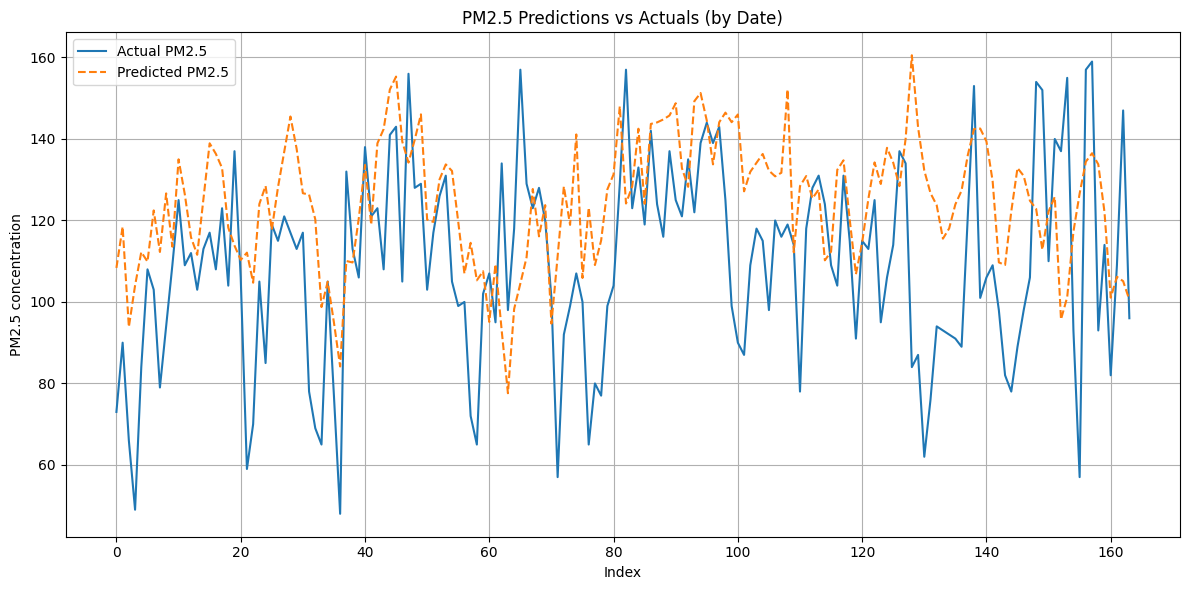

In [27]:
# Neural Net Evaluation
rmses = []

y_pred_nn = model.predict(X_test).flatten()
rmse = root_mean_squared_error(y_test.values, y_pred_nn)
rmses.append(rmse)

avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE: {avg_rmse}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual PM2.5', linewidth=1.5)
plt.plot(range(len(y_test)), y_pred_nn, label='Predicted PM2.5', linewidth=1.5, linestyle='--')

plt.title('PM2.5 Predictions vs Actuals (by Date)')
plt.xlabel('Index')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Explore feature importances
from sklearn.inspection import permutation_importance
imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, scoring='neg_root_mean_squared_error')
sorted(zip(X_test.columns, imp.importances_mean), key=lambda x: -x[1])[:10]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━

[('month_sin', np.float64(0.5346064004928639)),
 ('temp_max_wind_speed', np.float64(0.10574804968705784)),
 ('day_cos', np.float64(0.08639030071118725)),
 ('ws_pres', np.float64(0.07315332846773578)),
 ('ws2', np.float64(0.06632208048269739)),
 ('precip_log', np.float64(0.03387433516774756)),
 ('month_cos', np.float64(0.01982527002278047)),
 ('year', np.float64(0.0)),
 ('week_sin', np.float64(-0.006002721252835031)),
 ('dp1', np.float64(-0.006833245821176348))]

[0]	train-rmse:41.33441	val-rmse:48.70488
[200]	train-rmse:11.51575	val-rmse:27.46851
[400]	train-rmse:8.11630	val-rmse:27.54334
[468]	train-rmse:7.25311	val-rmse:27.58770

Average RMSE: 22.64344559871844


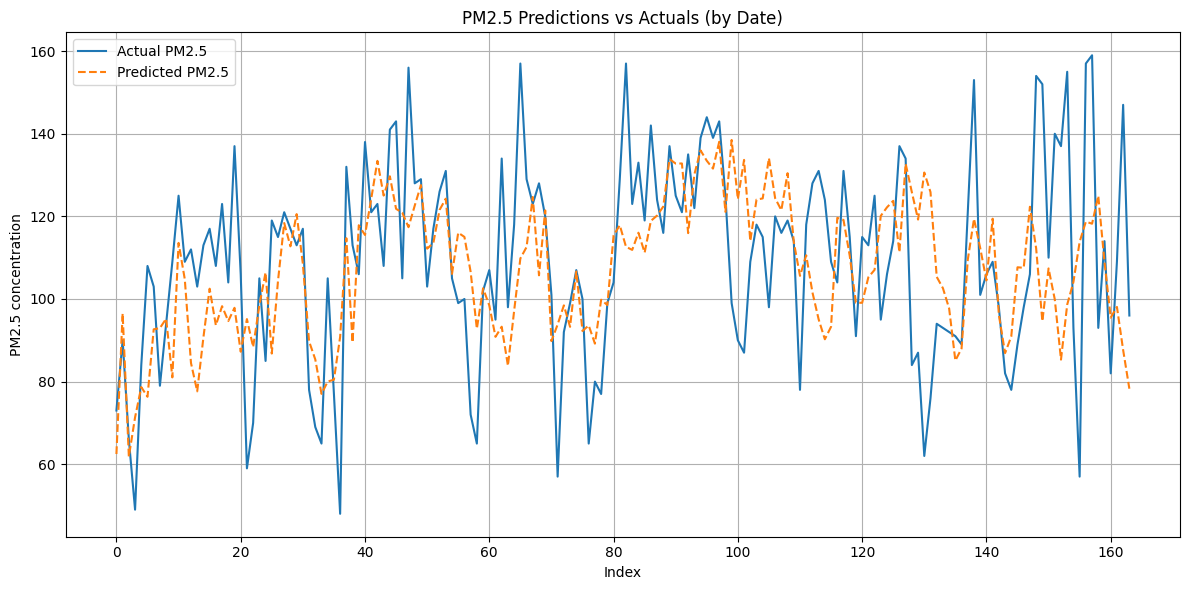

In [29]:
# XGB Evaluation
import xgboost as xgb

val_frac = 0.2
n = len(X_train)
cut = int(n*(1-val_frac))
X_tr_tree, y_tr_tree = X_train_tree[:cut], y_train_tree[:cut]
X_val_tree, y_val_tree = X_train_tree[cut:], y_train_tree[cut:]

# XGBR works better with preprocessed data
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

params = {"objective": "reg:squarederror",
          "eval_metric": "rmse",
          "eta": 0.03,
          "max_depth": 6,
          "min_child_weight": 20,
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "colsample_bynode": 0.8,
          "lambda": 1.5,
          "alpha": 0.0,
          "tree_method": "hist",
          "seed": 42}

xgbr = xgb.train(params, dtrain, num_boost_round=3000,
                 evals=[(dtrain, "train"), (dval, "val")],
                 early_stopping_rounds=200, verbose_eval=200)

y_pred_xgb = xgbr.predict(dtest, iteration_range=(0, xgbr.best_iteration))

rmses = []
rmse = root_mean_squared_error(y_test.values, y_pred_xgb)
rmses.append(rmse)

avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE: {avg_rmse}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual PM2.5', linewidth=1.5)
plt.plot(range(len(y_test)), y_pred_xgb, label='Predicted PM2.5', linewidth=1.5, linestyle='--')

plt.title('PM2.5 Predictions vs Actuals (by Date)')
plt.xlabel('Index')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid_0's rmse: 27.3278	valid_0's l2: 746.807

Average RMSE: 22.732507420162733


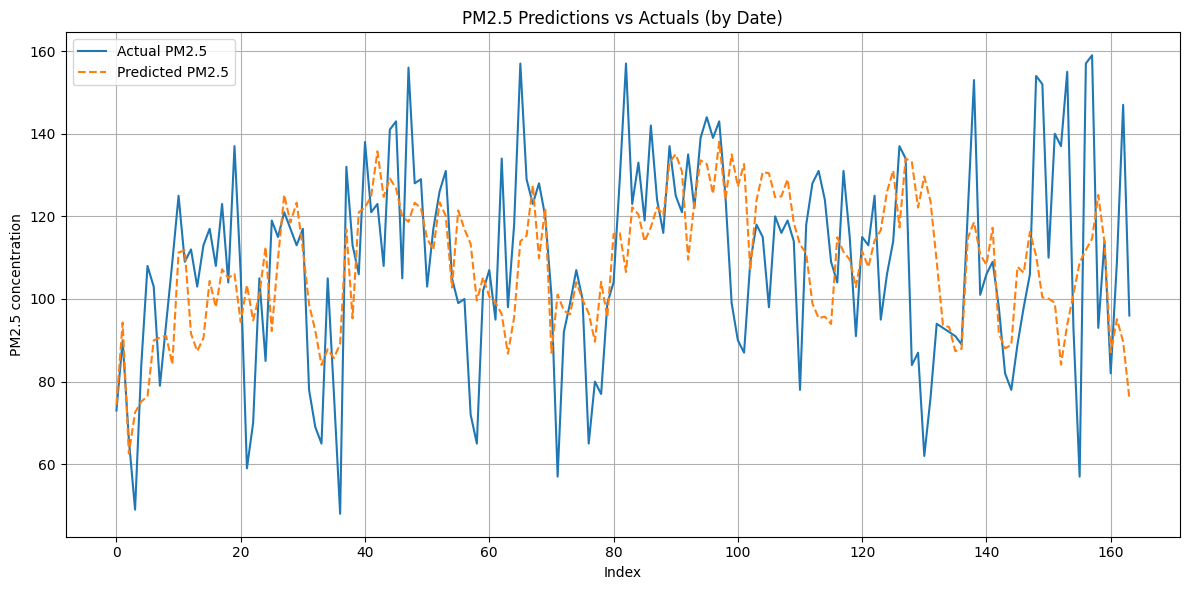

In [30]:
# LGBM Evaluation
lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
         eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])

y_pred_lgbm = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

rmses = []
rmse = root_mean_squared_error(y_test.values, y_pred_lgbm)
rmses.append(rmse)

avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE: {avg_rmse}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual PM2.5', linewidth=1.5)
plt.plot(range(len(y_test)), y_pred_lgbm, label='Predicted PM2.5', linewidth=1.5, linestyle='--')

plt.title('PM2.5 Predictions vs Actuals (by Date)')
plt.xlabel('Index')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Average RMSE: 24.68186788280448


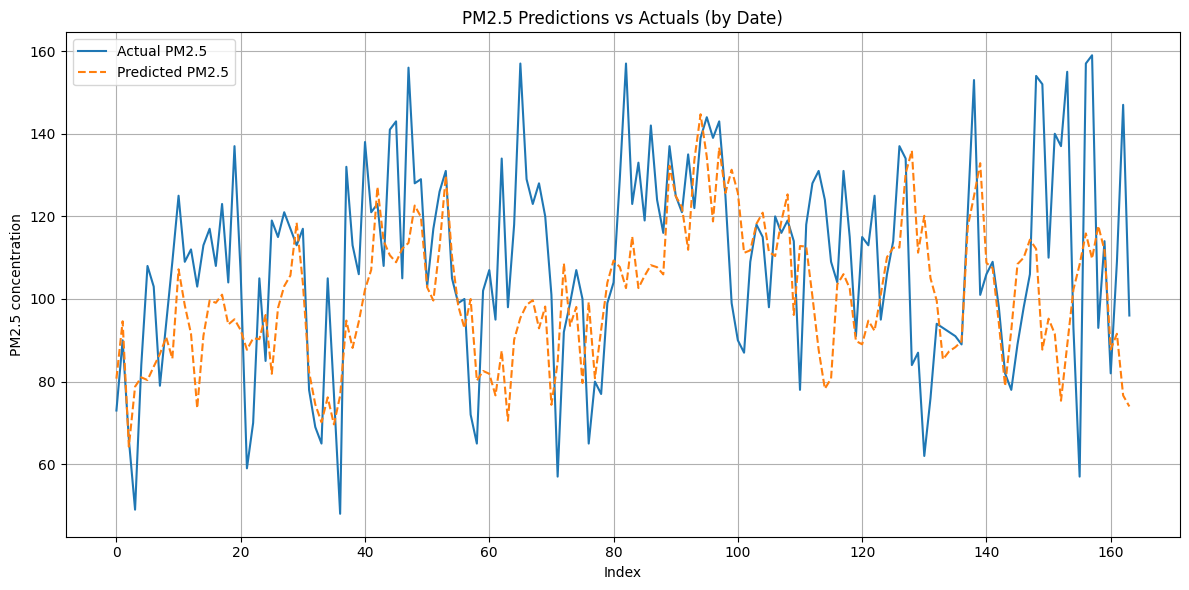

In [31]:
# Random Forest Evaluation
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmses = []
rmse = root_mean_squared_error(y_test.values, y_pred_rf)
rmses.append(rmse)

avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE: {avg_rmse}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual PM2.5', linewidth=1.5)
plt.plot(range(len(y_test)), y_pred_rf, label='Predicted PM2.5', linewidth=1.5, linestyle='--')

plt.title('PM2.5 Predictions vs Actuals (by Date)')
plt.xlabel('Index')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Average RMSE: 43.84870946583405


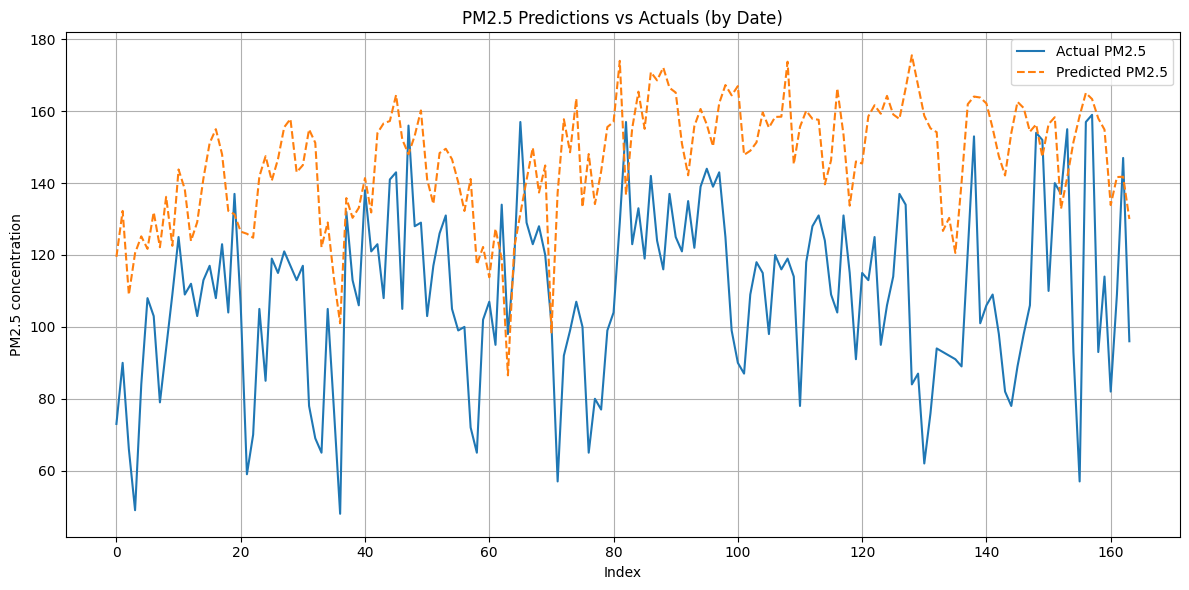

In [32]:
# Linear Regression Evaluation
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmses = []
rmse = root_mean_squared_error(y_test.values, y_pred_lr)
rmses.append(rmse)

avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE: {avg_rmse}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual PM2.5', linewidth=1.5)
plt.plot(range(len(y_test)), y_pred_lr, label='Predicted PM2.5', linewidth=1.5, linestyle='--')

plt.title('PM2.5 Predictions vs Actuals (by Date)')
plt.xlabel('Index')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Linear Regression
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Random Forest Regressor
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# LGBM Regressor
mae = mean_absolute_error(y_test, y_pred_lgbm)
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgbm)

print(f"LGBM Regressor - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# XGBoost Regressor
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Neural Net
mae = mean_absolute_error(y_test, y_pred_nn)
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

print(f"Neural Net - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")


Linear Regression - MAE: 38.18, MSE: 1922.71, RMSE: 43.85, R2: -2.36
Random Forest Regressor - MAE: 19.02, MSE: 609.19, RMSE: 24.68, R2: -0.07
LGBM Regressor - MAE: 17.09, MSE: 516.77, RMSE: 22.73, R2: 0.10
XGBoost Regressor - MAE: 17.36, MSE: 512.73, RMSE: 22.64, R2: 0.10
Neural Net - MAE: 22.65, MSE: 780.91, RMSE: 27.94, R2: -0.37


## **Forecasting**

In [34]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
 "latitude": -6.1781,
 "longitude": 106.63,
 "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "pressure_msl_mean", "temperature_2m_mean", "wind_speed_10m_mean"],
 "timezone": "GMT",
 "forecast_days": 7,
 # Past data for precipitation lag and rolling features
 "past_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_pressure_msl_mean = daily.Variables(3).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(4).ValuesAsNumpy()
daily_wind_speed_10m_mean = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
 start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
 end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
 freq = pd.Timedelta(seconds = daily.Interval()),
 inclusive = "left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["pressure_msl_mean"] = daily_pressure_msl_mean
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["wind_speed_10m_mean"] = daily_wind_speed_10m_mean

test_df = pd.DataFrame(data = daily_data)

Coordinates: -6.125°N 106.625°E
Elevation: 18.0 m asl
Timezone: NoneNone
Timezone difference to GMT+0: 0s


In [35]:
# Rename columns
test_df.rename(columns={'temperature_2m_max': 'temp_max',
                        'temperature_2m_min': 'temp_min',
                        'precipitation_sum': 'precip',
                        'pressure_msl_mean': 'pres',
                        'temperature_2m_mean': 'temp_avg',
                        'wind_speed_10m_mean': 'wind_speed'}, inplace=True)

test_df['date'] = pd.to_datetime(test_df['date'], utc=True).dt.normalize()
test_df

,date,temp_max,temp_min,precip,pres,temp_avg,wind_speed
0,2025-12-12 00:00:00+00:00,33.328503,24.728498,1.0,1007.658386,28.097254,7.846856
1,2025-12-13 00:00:00+00:00,33.328503,24.778500,0.3,1007.600037,28.136833,9.710311
2,2025-12-14 00:00:00+00:00,30.928499,24.828499,2.4,1008.308350,27.022247,13.898479
3,2025-12-15 00:00:00+00:00,32.378502,24.578499,0.1,1008.762512,27.603500,13.059038
4,2025-12-16 00:00:00+00:00,32.578503,24.778500,0.3,1008.708191,27.343079,13.213260
5,2025-12-17 00:00:00+00:00,30.928499,24.828499,0.7,1008.312439,27.274332,11.328193
6,2025-12-18 00:00:00+00:00,30.378500,24.428499,2.3,1007.354248,26.578501,10.732910
7,2025-12-19 00:00:00+00:00,29.828499,24.428499,4.0,1007.279114,26.478502,9.303761
8,2025-12-20 00:00:00+00:00,30.228498,24.678499,3.7,1007.283386,27.011835,7.443127
9,2025-12-21 00:00:00+00:00,31.378500,25.228498,8.1,1007.591614,27.676416,6.222167


In [36]:
# Impute missing values (if necessary)
test_df['precip'] = test_df['precip'].ffill().bfill()

In [37]:
test_df = test_df.set_index("date").asfreq("D")

# Change date to day, month, year
test_df.loc[:, 'day_of_week'] = test_df.index.dayofweek
test_df.loc[:, 'day_of_month'] = test_df.index.day
test_df.loc[:,'month'] = test_df.index.month
test_df.loc[:,'year'] = test_df.index.year
test_df.index = range(len(test_df))

# Interaction features
test_df_tree = test_df.copy()

test_df['temp_avg_precip'] = test_df['temp_avg'] * test_df['precip']
test_df['temp_avg_wind_speed'] = test_df['temp_avg'] * test_df['wind_speed']
test_df['temp_avg_pres'] = test_df['temp_avg'] * test_df['pres']

test_df['temp_min_precip'] = test_df['temp_min'] * test_df['precip']
test_df['temp_min_wind_speed'] = test_df['temp_min'] * test_df['wind_speed']
test_df['temp_min_pres'] = test_df['temp_min'] * test_df['pres']

test_df['temp_max_precip'] = test_df['temp_max'] * test_df['precip']
test_df['temp_max_wind_speed'] = test_df['temp_max'] * test_df['wind_speed']
test_df['temp_max_pres'] = test_df['temp_max'] * test_df['pres']

test_df['wind_speed_pres'] = test_df['wind_speed'] * test_df['pres']
test_df['wind_speed_precip'] = test_df['wind_speed'] * test_df['precip']

test_df['pres_precip'] = test_df['pres'] * test_df['precip']

# Cyclical features
test_df.loc[:, 'week_sin'] = np.sin(2 * np.pi * test_df['day_of_week']/7)
test_df.loc[:, 'week_cos'] = np.cos(2 * np.pi * test_df['day_of_week']/7)

test_df.loc[:, 'month_sin'] = np.sin(2 * np.pi * test_df['month']/12)
test_df.loc[:, 'month_cos'] = np.cos(2 * np.pi * test_df['month']/12)

test_df.loc[:, 'day_sin'] = np.sin(2 * np.pi * test_df['day_of_month']/31)
test_df.loc[:, 'day_cos'] = np.cos(2 * np.pi * test_df['day_of_month']/31)

# More features
test_df['temp_range'] = test_df['temp_max'] - test_df['temp_min']
test_df['dp1'] = test_df['pres'].diff(1)
test_df['dp3'] = test_df['pres'].diff(3)

p_lag1 = test_df['precip'].shift(1)

test_df['rain_any_1d'] = (p_lag1 > 0).astype('float')  # keep float for now (has NaN on first row)
test_df['rain_sum_3d'] = p_lag1.rolling(3, min_periods=3).sum()
test_df['rain_sum_7d'] = p_lag1.rolling(7, min_periods=7).sum()

test_df['ws2'] = test_df['wind_speed']**2
test_df['ws_dtr'] = test_df['wind_speed'] * test_df['temp_range']
test_df['ws_pres'] = test_df['wind_speed'] * test_df['pres']

test_df = test_df.iloc[7:]

# Split train test
# Scale values
test_df['precip_log'] = np.log1p(test_df['precip'])

test_df = test_df.drop(['precip'], axis=1)

features = ['temp_avg', 'temp_min', 'temp_max', 'precip_log', 'wind_speed',
           'pres', 'temp_avg_precip', 'temp_avg_wind_speed', 'temp_avg_pres',
           'temp_min_precip', 'temp_min_wind_speed', 'temp_min_pres',
           'temp_max_precip', 'temp_max_wind_speed', 'temp_max_pres',
           'wind_speed_pres', 'wind_speed_precip', 'pres_precip',
           'temp_range', 'dp1', 'dp3', 'rain_any_1d', 'rain_sum_3d', 'rain_sum_7d',
           'ws2', 'ws_dtr', 'ws_pres']

test_df[features] = test_df[features].astype("float64")
test_df[features] = scaler.transform(test_df[features])

test_df.loc[:, 'year'] -= 2020

# Remove date features
features = ['day_of_week', 'day_of_month', 'month']

# Remove for tabular models
test_df = test_df.drop(features, axis=1)

# Align columns
TRAIN_COLS = X_tr.columns.tolist()
test_aligned = test_df.loc[:, TRAIN_COLS].astype(np.float32)

# XGB Data
dtest_df  = xgb.DMatrix(test_aligned)

In [38]:
forecast = xgbr.predict(dtest_df)
forecast_df = pd.DataFrame(forecast)

In [39]:
# PM25 Predictions
forecast_df

,0
0,83.113144
1,106.290894
2,91.910789
3,103.373810
4,99.090904
5,106.564857
6,104.434052


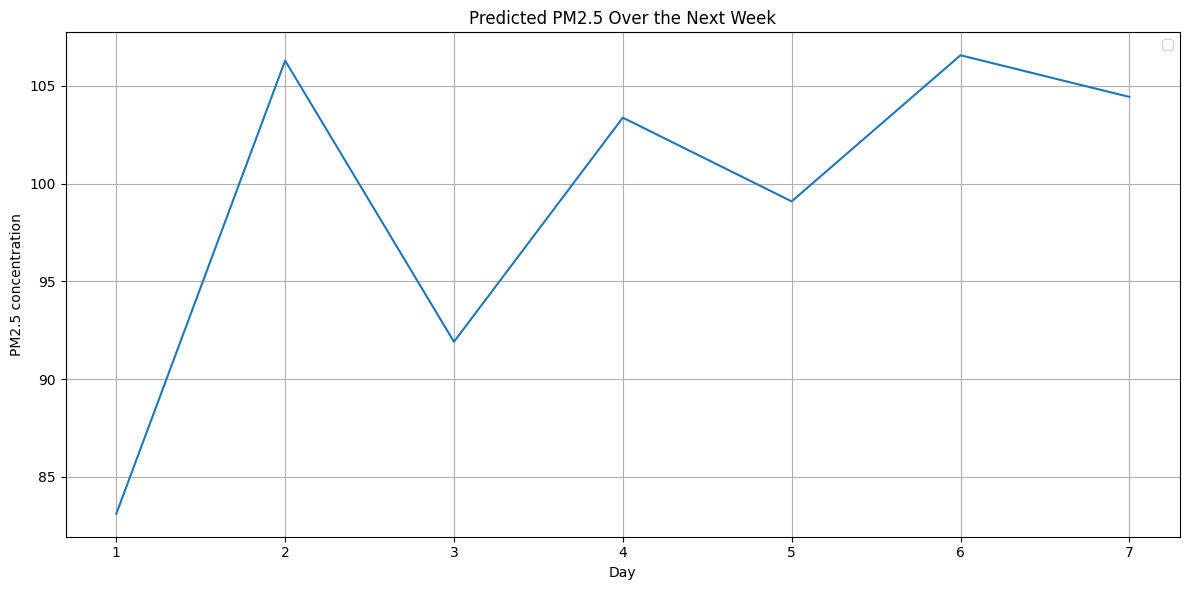

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(forecast_df)+1), forecast_df, linewidth=1.5)

plt.title('Predicted PM2.5 Over the Next Week')
plt.xlabel('Day')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()